In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading and Initial Preprocessing

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Project/1. Forecast/household_power_consumption.csv")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
df["timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"])
df = df.set_index("timestamp")
df = df.sort_index()

/tmp/ipython-input-2797048051.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"])


## Data Aggregation and Missing Value Handling

In [ ]:
numeric_cols = [
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3"
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# ---- Hourly Aggregation (mean per hour) ----
df_hourly = df["Global_active_power"].resample("H").mean()

# ---- Handle missing hours ----
df_hourly = df_hourly.interpolate()

print("Hourly series shape:", df_hourly.shape)

Hourly series shape: (17477,)


/tmp/ipython-input-1775646764.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df["Global_active_power"].resample("H").mean()


## Train-Test Split

In [ ]:
train_size = int(len(df_hourly) * 0.8)
train = df_hourly.iloc[:train_size]
test  = df_hourly.iloc[train_size:]

print("Train points:", len(train))
print("Test points:", len(test))

Train points: 13981
Test points: 3496


## Data Scaling

In [ ]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1,1))
test_scaled  = scaler.transform(test.values.reshape(-1,1))

## Sequence Creation for LSTM

In [ ]:
def make_sequences(data, window=24):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

WINDOW = 24

X_train, y_train = make_sequences(train_scaled, WINDOW)
X_test,  y_test  = make_sequences(test_scaled,  WINDOW)

## Reshaping Data for LSTM Input

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0],  X_test.shape[1],  1))

## LSTM Model Definition

In [ ]:
model = Sequential([
    LSTM(64, activation="tanh", return_sequences=True, input_shape=(WINDOW,1)),
    LSTM(32, activation="tanh"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - loss: 0.0221 - val_loss: 0.0095
Epoch 2/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0118 - val_loss: 0.0095
Epoch 3/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0116 - val_loss: 0.0099
Epoch 4/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.0108 - val_loss: 0.0084
Epoch 5/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.0107 - val_loss: 0.0085
Epoch 6/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.0105 - val_loss: 0.0083
Epoch 7/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.0105 - val_loss: 0.0096
Epoch 8/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0104 - val_loss: 0.0083
Epoch 9/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0101 - val_loss: 0.0082
Epoch 10/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.0101 - val_loss: 0.0084
Epoch 11/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0100 - val_loss: 0.0083
Epoch 12/20
393/393 ━━━━━━━━━━━━

## Model Prediction

In [ ]:
y_pred_scaled = model.predict(X_test)

109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


## Inverse Transform Predictions

In [ ]:
y_pred = scaler.inverse_transform(y_pred_scaled).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

## Aligning Predictions with Test Index

In [ ]:
test_aligned_index = test.index[WINDOW:]

lstm_predictions = pd.Series(y_pred, index=test_aligned_index)
lstm_actual = pd.Series(y_true, index=test_aligned_index)

## Model Evaluation

In [ ]:
mae  = mean_absolute_error(lstm_actual, lstm_predictions)
rmse = np.sqrt(mean_squared_error(lstm_actual, lstm_predictions))
mape = (abs((lstm_actual - lstm_predictions) / lstm_actual).mean()) * 100
smape = (2 * np.mean(np.abs(lstm_predictions - lstm_actual) /
        (np.abs(lstm_actual) + np.abs(lstm_predictions)))) * 100

print("\nLSTM Model Performance (Hourly, 24h window)")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"sMAPE: {smape:.2f}%")


LSTM Model Performance (Hourly, 24h window)
MAE  : 0.3556
RMSE : 0.5335
MAPE : 55.24%
sMAPE: 41.38%


## Visualization of Results

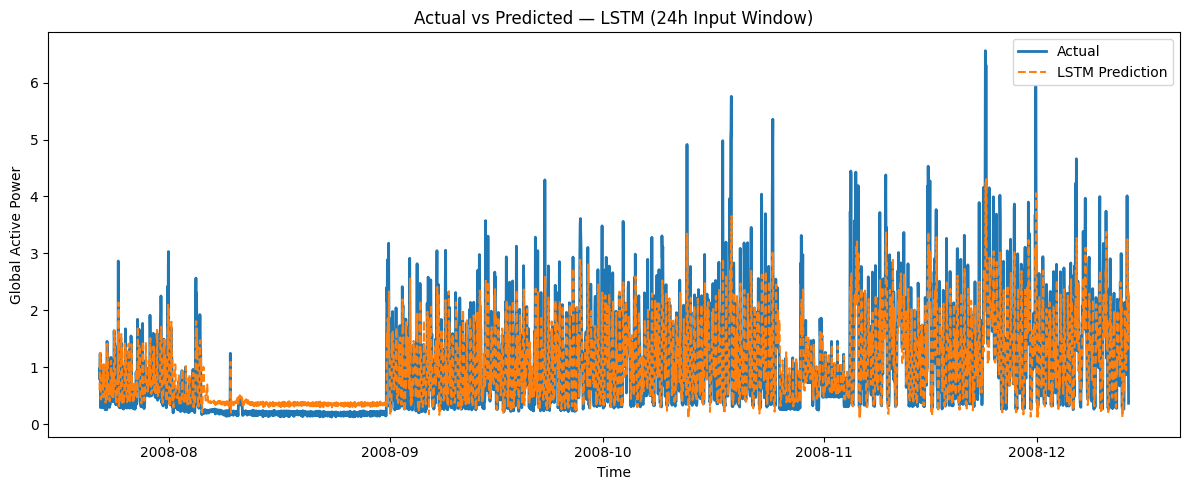

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(lstm_actual, label="Actual", linewidth=2)
plt.plot(lstm_predictions, label="LSTM Prediction", linestyle="--")

plt.title("Actual vs Predicted — LSTM (24h Input Window)")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.legend()
plt.tight_layout()
plt.show()

## Displaying Predictions DataFrame

In [ ]:
lstm_results_df = pd.DataFrame({
    "Actual": lstm_actual,
    "LSTM_24h_Prediction": lstm_predictions
})

lstm_results_df.head()

,Actual,LSTM_24h_Prediction
timestamp,,
2008-07-22 06:00:00,0.968067,0.596073
2008-07-22 07:00:00,0.781733,1.237999
2008-07-22 08:00:00,1.240467,0.972618
2008-07-22 09:00:00,0.290600,1.252924
2008-07-22 10:00:00,0.292800,0.431466
